In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
bs = 100

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)) # Changed to single values for mean and std
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))


class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [ ]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [ ]:

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

In [ ]:
n_epoch = 200
for epoch in range(1, n_epoch+1):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/200]: loss_d: 0.997, loss_g: 2.470
[2/200]: loss_d: 1.120, loss_g: 1.474
[3/200]: loss_d: 1.054, loss_g: 1.590
[4/200]: loss_d: 0.929, loss_g: 2.195
[5/200]: loss_d: 0.672, loss_g: 2.364
[6/200]: loss_d: 0.527, loss_g: 2.773
[7/200]: loss_d: 0.610, loss_g: 2.551
[8/200]: loss_d: 0.652, loss_g: 2.356
[9/200]: loss_d: 0.633, loss_g: 2.437
[10/200]: loss_d: 0.670, loss_g: 2.403
[11/200]: loss_d: 0.594, loss_g: 2.537
[12/200]: loss_d: 0.648, loss_g: 2.434
[13/200]: loss_d: 0.693, loss_g: 2.289
[14/200]: loss_d: 0.744, loss_g: 2.084
[15/200]: loss_d: 0.744, loss_g: 2.080
[16/200]: loss_d: 0.722, loss_g: 2.119
[17/200]: loss_d: 0.745, loss_g: 2.006
[18/200]: loss_d: 0.811, loss_g: 1.828
[19/200]: loss_d: 0.831, loss_g: 1.832
[20/200]: loss_d: 0.880, loss_g: 1.640
[21/200]: loss_d: 0.916, loss_g: 1.597
[22/200]: loss_d: 0.954, loss_g: 1.502
[23/200]: loss_d: 0.915, loss_g: 1.562
[24/200]: loss_d: 0.974, loss_g: 1.460
[25/200]: loss_d: 0.958, loss_g: 1.509
[26/200]: loss_d: 0.934, loss_g: 1

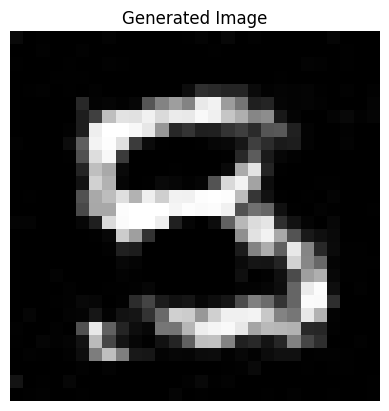

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a random noise vector
z = torch.randn(1, z_dim).to(device)

# Generate an image using the generator
G.eval() # Set the generator to evaluation mode
with torch.no_grad():
    generated_image = G(z).view(28, 28).cpu().numpy()

# Display the generated image
plt.imshow(generated_image, cmap='gray')
plt.title("Generated Image")
plt.axis("off")
plt.show()

In [ ]:
import torch

# Define the path to save the model
model_save_path = 'generator_model.pth'

# Save the generator's state dictionary
torch.save(G.state_dict(), model_save_path)

print(f"Generator model saved to {model_save_path}")

Generator model saved to generator_model.pth
